<a href="https://colab.research.google.com/github/Parham-nooran/Reinforcement-Learning/blob/master/SARSA_%26_Q_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SARSA & Q-Learning

### *Full Name:* Parham Nooranbakht

In [ ]:
# installing packages
!pip install gym==0.26
!pip install imageio imageio_ffmpeg
!pip install pygame
!pip install pyglet==1.5.1 
!apt install python-opengl
!apt install ffmpeg
!apt install xvfb
!pip3 install pyvirtualdisplay

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-opengl is already the newest version (3.1.0+dfsg-2build1).
0 upgraded, 0 newly installed, 0 to remove and 23 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:4.2.7-0ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 23 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.20.13-1ubuntu1~20.04.5)

In [ ]:
# importing packages
import numpy as np
import gym
from tqdm.notebook import tqdm
from IPython.display import HTML
from base64 import b64encode
import imageio

In this notebook, we are going to use the [openai gym](https://www.gymlibrary.dev/) library to implement an agent on the mountain car environment. you will have to implement both SARSA and Q-Learning algorithm to solve this problem. use google colab to run this notebook.

In [ ]:
# we will use these two functions to visualize the environment
def record_video_mountain_car_env(env, Qtable, out_directory, fps=1, det_action=(False, 0), max_steps=500):
    images = []  
    truncated, done = False, False
    state, info = env.reset(seed=np.random.randint(0,500))
    state = discretize_state(state) if not det_action[0] else None
    img = env.render()
    images.append(img)
    step = 0
    while step < max_steps and not done:
        # Take the action (index) that have the maximum expected future reward given that state
        action = np.argmax(Qtable[state[0]][state[1]][:]) if not det_action[0] else det_action[1]
        state, reward, done, truncated, info = env.step(action)
        state = discretize_state(state) if not det_action[0] else None
        img = env.render()
        images.append(img)
        step += 1
    imageio.mimsave(out_directory, [np.array(img) for i, img in enumerate(images)], fps=fps)

def show_video(video_path, video_width = 600):
    video_file = open(video_path, "r+b").read()
    video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
    return HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""")

## Mountain Car Environment

The Mountain Car MDP is a deterministic MDP that consists of a car placed stochastically at the bottom of a sinusoidal valley, with the only possible actions being the accelerations that can be applied to the car in either direction. The goal of the MDP is to strategically accelerate the car to reach the goal state on top of the right hill.

The state of the car is represented by its velocity and position along the x axis. the velocity is a number between -0.07, 0.07 and the position is a number between -1.3, 0.6. There are 3 discrete deterministic actions: (0:Accelerate to the left, 1:Don’t accelerate, 2:Accelerate to the right)
The starting position of the car is different each time we run the environment.

In order to use the gym environment we first need to create it with the following code.

In [ ]:
env = gym.make("MountainCar-v0", render_mode='rgb_array')

you can execute an action on gym environment using the env.step(action). The possible actions for this environment are (0:Accelerate to the left, 1:Don’t accelerate, 2:Accelerate to the right).

In [ ]:
print(f'possible actions are f{env.action_space}')
print(f'obseration space is f{env.observation_space}')
action = 2 # accelerate right
env.reset()
state, reward, done, truncated, info = env.step(action)
print(f'state={state}, reward={reward}, done={done}, truncated={truncated}, info={info}')

possible actions are fDiscrete(3)
obseration space is fBox([-1.2  -0.07], [0.6  0.07], (2,), float32)
state=[-0.4497494   0.00045397], reward=-1.0, done=False, truncated=False, info={}


Lets visualize the environment using a fix policy of always acclerating to the right. As you can see we don't do well at all.

In [ ]:
record_video_mountain_car_env(env, None, 'mountaincar_always_right.mp4', fps=15, det_action=(True,2))
show_video('mountaincar_always_right.mp4', video_width = 600)

in order to construct the Q-table we need to discretize the observation space of the environment. complete the next function to achieve this goal. we suggest that you use step size 0.1 for the position and the step size 0.01 for the velocity. 

In [ ]:
def discretize_state(state, step_velocity=0.01, step_position=0.1):
    """
    Implement a function discretize the state.

    Arguments:
    state -- tuple containing (position, velocity)
    step_velocity -- step size for velocity
    step_position -- step size for position

    Returns:
    tuple containing the discrete state (position, velocity)
    """
    # complete this function
    low = env.observation_space.low
    high = env.observation_space.high
    position = np.argmin((np.arange(low[0], high[0], step_position) - state[0])**2)
    velocity = np.argmin((np.arange(low[1], high[1], step_velocity) - state[1])**2)
    return position, velocity

create the qtable as a numpy array of shape (step state count, position state count, action count)

In [ ]:
def initialize_q_table(step_position_count, step_velocity_count, action_count):
  """
    Implement a function to create the Qtable.

    Arguments:
    step_position_count -- total state count for position
    step_velocity_count -- total state count for velocity
    action_count -- count of possible actions

    Returns:
    tuple containing the discrete state (position state count, velocity state count, action count)
  """
  Qtable = np.zeros((step_position_count, step_velocity_count, action_count))
  return Qtable

implement a sarsa and qlearning agent by completing these two functions.

In [ ]:
def train(n_training_episodes, learning_rate, gamma, step_velocity, step_position, 
          min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable, sarsa=False):
  for episode in tqdm(range(n_training_episodes)):
    # Adjust epsilon
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * episode)
    # Reset the environment
    state, info = env.reset()
    state = discretize_state(state, step_velocity, step_position)
    step = 0
    done = False

    # repeat
    score = 0
    for step in range(max_steps):
      # choose from epsilon greedy policy
      action = env.action_space.sample() if (np.random.random() < epsilon) else np.argmax(Qtable[state[0]][state[1]][:])
      next_state, reward, done, truncated, info = env.step(action)
      next_state = discretize_state(next_state, step_velocity, step_position)
      # update the Qtable based on the algorithm
      next_q = np.max(Qtable[next_state[0]][next_state[1]][:])
      if sarsa:
        next_q =  Qtable[next_state[0]][next_state[1]][env.action_space.sample()] if (np.random.random() < epsilon) else next_q
      Qtable[state[0]][state[1]][action] += learning_rate * (reward + gamma * next_q - Qtable[state[0]][state[1]][action])
      # Qtable[state, action] += learning_rate * (reward + gamma * np.max(Qtable[next_state]) - Qtable[state, action])
      score += reward
      if (done): 
            break
      state = next_state
    if episode % 500 == 0:
      print(f"Episode: {episode}, Score: {score}")
  return Qtable

now train your model. you may use other hyperparameters.

In [ ]:
# hyperparameters

# Training parameters
n_training_episodes = 20_000  # Total training episodes
learning_rate = 0.02           # Learning rate

# Environment parameters
max_steps = 200               # Max steps per episode
gamma = 0.95                 # Discounting rate

# Exploration parameters
min_epsilon = 0.01            # Minimum exploration probability 
max_epsilon = 1.0             # Exploration probability at start
decay_rate = 0.99           # Exponential decay rate for exploration prob
step_velocity = 0.01
step_position = 0.1

In [ ]:
low = env.observation_space.low
high = env.observation_space.high
Qtable = initialize_q_table(int((high[0] - low[0])/step_position)+1,
                            int((high[1] - low[1])/step_velocity)+1,
                            env.action_space.n)

In [ ]:
Qtable_trained = train(n_training_episodes, learning_rate, gamma, step_velocity,
                       step_position, min_epsilon, max_epsilon, decay_rate, env,
                       max_steps, Qtable)
np.save('Qtable.npy', Qtable_trained)

  0%|          | 0/20000 [00:00<?, ?it/s]

Episode: 0, Score: -200.0
Episode: 500, Score: -200.0
Episode: 1000, Score: -200.0
Episode: 1500, Score: -200.0
Episode: 2000, Score: -200.0
Episode: 2500, Score: -200.0
Episode: 3000, Score: -200.0
Episode: 3500, Score: -200.0
Episode: 4000, Score: -158.0
Episode: 4500, Score: -158.0
Episode: 5000, Score: -200.0
Episode: 5500, Score: -188.0
Episode: 6000, Score: -200.0
Episode: 6500, Score: -200.0
Episode: 7000, Score: -164.0
Episode: 7500, Score: -200.0
Episode: 8000, Score: -200.0
Episode: 8500, Score: -157.0
Episode: 9000, Score: -200.0
Episode: 9500, Score: -169.0
Episode: 10000, Score: -200.0
Episode: 10500, Score: -158.0
Episode: 11000, Score: -160.0
Episode: 11500, Score: -140.0
Episode: 12000, Score: -147.0
Episode: 12500, Score: -141.0
Episode: 13000, Score: -163.0
Episode: 13500, Score: -200.0
Episode: 14000, Score: -139.0
Episode: 14500, Score: -157.0
Episode: 15000, Score: -200.0
Episode: 15500, Score: -160.0
Episode: 16000, Score: -154.0
Episode: 16500, Score: -149.0
Epis

In [ ]:
Qtable_trained_sarsa = train(n_training_episodes, learning_rate, gamma,
                             step_velocity, step_position, min_epsilon,
                             max_epsilon, decay_rate, env, max_steps,
                             Qtable, sarsa=True)
np.save('SARSA_Qtable.npy', Qtable_trained_sarsa)

  0%|          | 0/20000 [00:00<?, ?it/s]

Episode: 0, Score: -200.0
Episode: 500, Score: -155.0
Episode: 1000, Score: -182.0
Episode: 1500, Score: -155.0
Episode: 2000, Score: -138.0
Episode: 2500, Score: -151.0
Episode: 3000, Score: -144.0
Episode: 3500, Score: -200.0
Episode: 4000, Score: -136.0
Episode: 4500, Score: -152.0
Episode: 5000, Score: -144.0
Episode: 5500, Score: -174.0
Episode: 6000, Score: -153.0
Episode: 6500, Score: -140.0
Episode: 7000, Score: -145.0
Episode: 7500, Score: -146.0
Episode: 8000, Score: -141.0
Episode: 8500, Score: -162.0
Episode: 9000, Score: -169.0
Episode: 9500, Score: -167.0
Episode: 10000, Score: -173.0
Episode: 10500, Score: -168.0
Episode: 11000, Score: -175.0
Episode: 11500, Score: -168.0
Episode: 12000, Score: -200.0
Episode: 12500, Score: -200.0
Episode: 13000, Score: -194.0
Episode: 13500, Score: -200.0
Episode: 14000, Score: -138.0
Episode: 14500, Score: -193.0
Episode: 15000, Score: -160.0
Episode: 15500, Score: -158.0
Episode: 16000, Score: -200.0
Episode: 16500, Score: -200.0
Epis

# Report & Questions


train your model both with Sarsa and Q-learning algorithms. Upload the video of your model in quera otherwise your homework will not be graded. In order to get the full mark the car must reach the highest point in both cases

In [ ]:
record_video_mountain_car_env(env, Qtable_trained, 'mountaincar_q_learning.mp4', fps=10)
show_video('mountaincar_q_learning.mp4', video_width = 600)

The car has reached the highest point in 16 seconds (10fps) using Q-learning algorithm.

In [ ]:
record_video_mountain_car_env(env, Qtable_trained_sarsa, 'mountaincar_sarsa.mp4', fps=15)
show_video('mountaincar_sarsa.mp4', video_width = 600)

The car has reached the highest point in 10 seconds (10 fps) using SARSA algorithm.

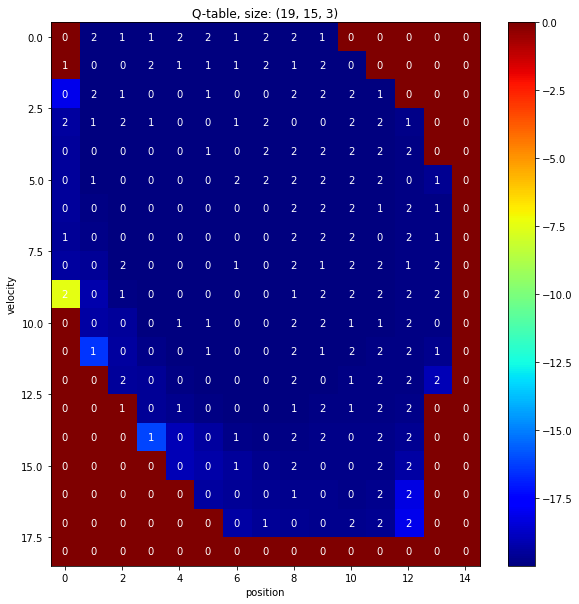

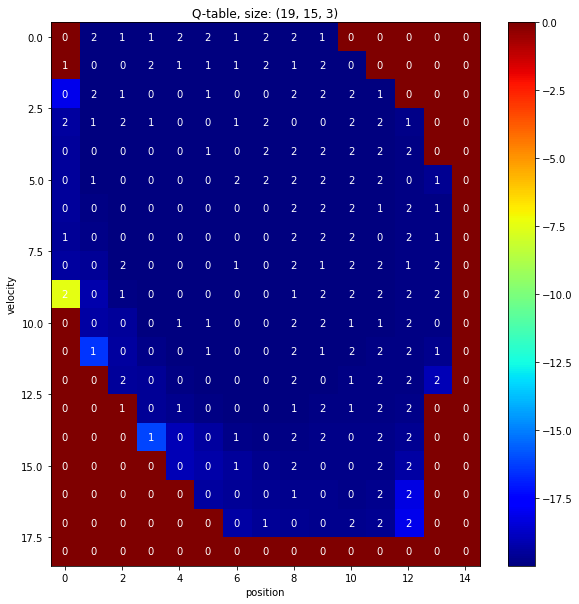

In [ ]:
import matplotlib.pyplot as plt 
def plot_q_table(q_table):
    q_image = np.max(q_table, axis=2) 
    q_actions = np.argmax(q_table, axis=2)

    fig, ax = plt.subplots(figsize=(10, 10))
    cax = ax.imshow(q_image, cmap='jet');
    cbar = fig.colorbar(cax)
    for x in range(q_image.shape[0]):
        for y in range(q_image.shape[1]):
            ax.text(y, x, q_actions[x, y], color='white',
                    horizontalalignment='center', verticalalignment='center')
    ax.grid(False)
    ax.set_title("Q-table, size: {}".format(q_table.shape))
    ax.set_xlabel('position')
    ax.set_ylabel('velocity')


plot_q_table(Qtable_trained)
plot_q_table(Qtable_trained_sarsa)

answer the following question

1. Why may we prefer Sarsa to Q-learning?  
SARSA is on-policy while Q-learning is off-policy. Off-policy means that each update can use data collected at any point during training, regardless of how the agent was choosing to explore the environment when the data was obtained. On-policy means that each update only uses data collected while acting according to the most recent version of the policy.
The major difference between SARSA and Q-Learning, is that the maximum reward for the next state is not necessarily used for updating the Q-values. Instead, a new action, and therefore reward, is selected using the same policy that determined the original action.
In Q learning, we take action using an epsilon-greedy policy and, while updating the Q value, we simply pick up the maximum action. In SARSA, we take the action using the epsilon-greedy policy and also, while updating the Q value, we pick up the action using the epsilon-greedy policy.
From our results we can conclude that the Sarsa algorithm has a faster convergence characteristic and sometimes gives a better final performance. Sarsa learns the safe path, along the top row of the grid because it takes the action selection method into account when learning. Because Sarsa learns the safe path, it actually receives a higher average reward per trial than Q-Learning even though it does not walk the optimal path. So in any case in wich we want to find the safe path fast, we should use SARSA. 